In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx
import pystan_utils
import itertools

plt.style.use('ggplot')
%matplotlib inline

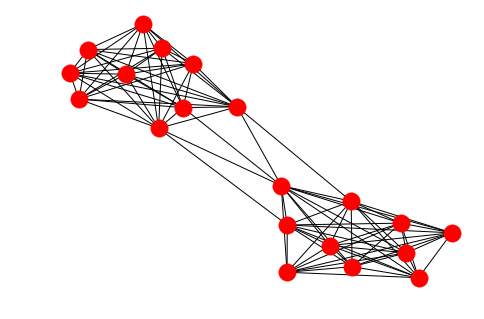

In [2]:
num_each = 20
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 5
between = 10
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T


mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)

mat[0,-1] = mat[-1,0] = np.random.poisson(between)
mat[0,-2] = mat[-2,0] = np.random.poisson(between)
mat[1,-2] = mat[-2,1] = np.random.poisson(between)
mat[2,-2] = mat[-2,2] = np.random.poisson(between)
mat[2,-3] = mat[-3,2] = np.random.poisson(between)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [2]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [3]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3be6d669e276c97fe04930ee9ae1728c NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpnlt51ham/stanfit4anon_model_3be6d669e276c97fe04930ee9ae1728c_2437285055834775798.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
n = num_each
k = 2
#alpha = sparse_alpha(5, k)
alpha = np.ones(2)
data = {'X' : mat, 'N' : n, 'K' : k, 'alpha' : alpha, 'a' : 7.5, 'b' : 1, 'c':5, 'd':3}
fit = sm.vb(data=data, iter=10000)

In [6]:
pies = pystan_utils.vb_extract_variable(fit, "pi", var_type="matrix", dims=[k,n])

In [29]:
extract = pystan_utils.vb_extract(fit)

In [32]:
np.argmax(pies, axis = 0)

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [8]:
groups = np.argmax(pies,axis=0)

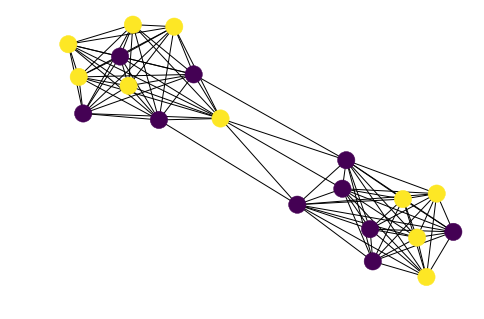

In [9]:
#pi = pies
#groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

/home/david/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


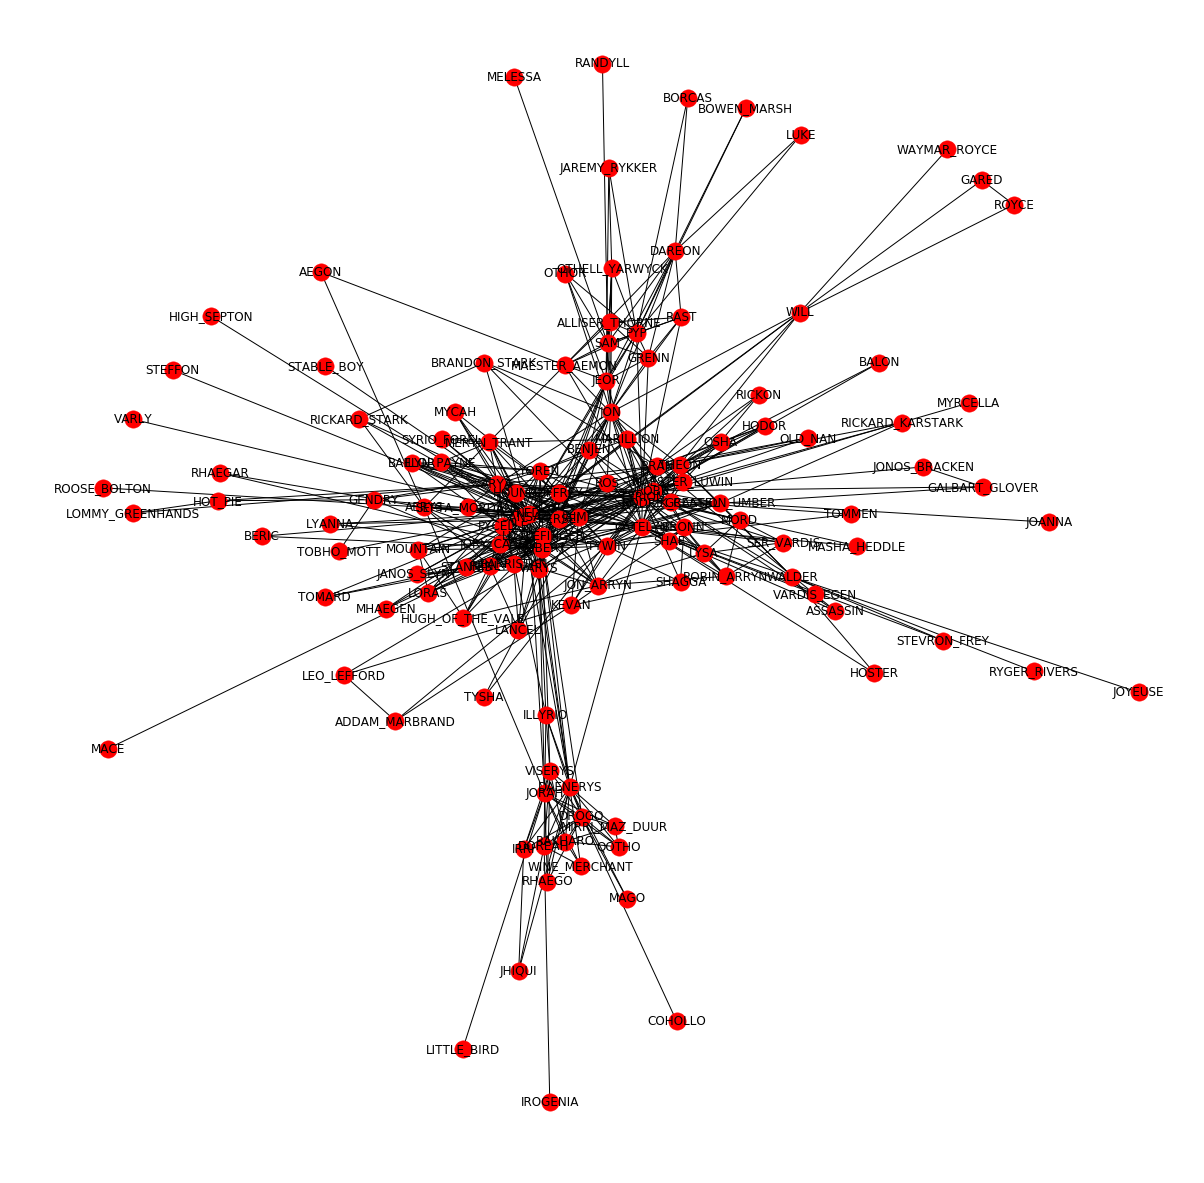

In [2]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s1-nodes.csv')
edges = pd.read_csv('../data/got-s1-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,16))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [3]:
def sparse_alpha(A, K):
    alpha = np.zeros(3*K)
    alpha[:K] = A
    
    for idx,i in enumerate(range(K,3*K)):
        alpha[i] = A*np.exp(-0.25*idx)
    
    return alpha


In [5]:
n = graph.shape[0]
k = 5
iterations = 10000
alpha = np.ones(k)
#alpha = sparse_alpha(5, k)
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.1, 'b' :  0.1, 'c': 0.5,'d': 0.5}

In [6]:
fit = sm.vb(data = data, iter = iterations, output_samples = iterations)

In [37]:
fitvar = pystan_utils.vb_extract(fit)

In [38]:
var_names = fit["sampler_param_names"]
samples = np.array([x for x in fit["sampler_params"]])

(array([2.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 1.500e+01, 4.900e+01,
        2.240e+02, 1.027e+03, 4.378e+03, 4.294e+03]),
 array([0.93720839, 0.9433211 , 0.94943381, 0.95554653, 0.96165924,
        0.96777195, 0.97388466, 0.97999737, 0.98611008, 0.9922228 ,
        0.99833551]),
 <a list of 10 Patch objects>)

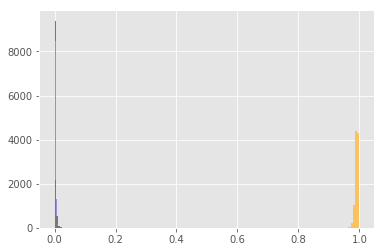

In [45]:
# Ned stark
plt.hist(fitvar[0]['pi[127,1]'])
plt.hist(fitvar[0]['pi[76,2]'])
plt.hist(fitvar[0]['pi[76,3]'])
plt.hist(fitvar[0]['pi[76,4]'])
plt.hist(fitvar[0]['pi[76,5]'])


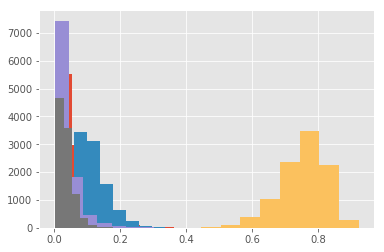

In [40]:
# Robert
plt.hist(fitvar[0]['pi[94,1]'])
plt.hist(fitvar[0]['pi[94,2]'])
plt.hist(fitvar[0]['pi[94,3]'])
plt.hist(fitvar[0]['pi[94,4]'])
plt.hist(fitvar[0]['pi[94,5]'])
plt.show()

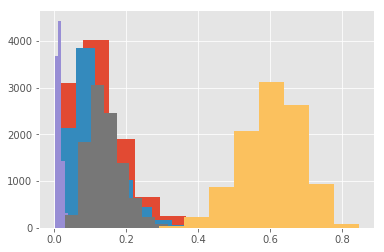

In [107]:
# Cersei
plt.hist(fitvar[0]['pi[18,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[18,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[18,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[18,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[18,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.xlim(0,1)
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.savefig("Cersei")
plt.show()

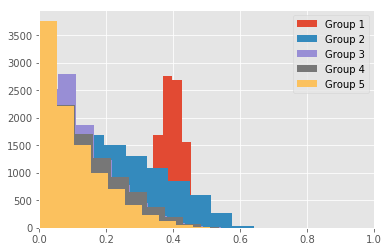

In [59]:
# Jamie
plt.hist(fitvar[0]['pi[39,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[39,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[39,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[39,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[39,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.xlim(0,1)
plt.show()

(0, 1)

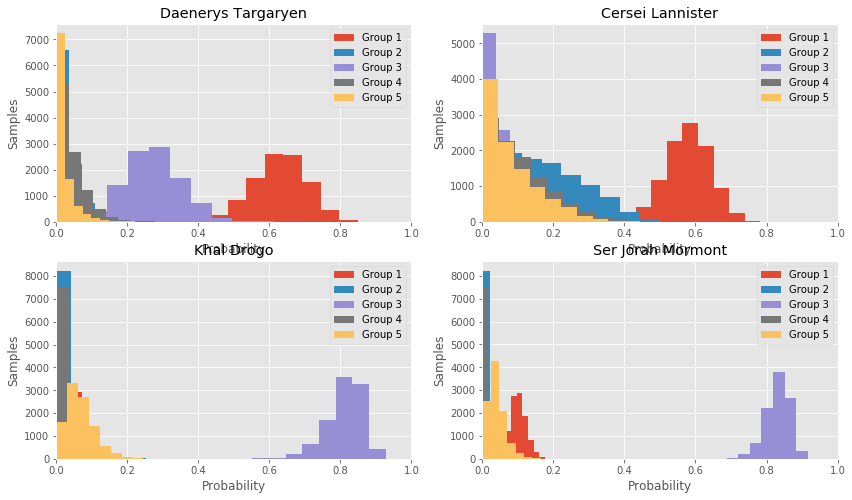

In [125]:
# Drogo
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.hist(fitvar[0]['pi[20,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[20,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[20,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[20,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[20,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Daenerys Targaryen")
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.xlim(0,1)


plt.subplot(2,2,2)
plt.hist(fitvar[0]['pi[18,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[18,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[18,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[18,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[18,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Cersei Lannister")
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.xlim(0,1)


plt.subplot(2,2,3)
plt.hist(fitvar[0]['pi[23,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[23,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[23,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[23,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[23,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Khal Drogo")
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.xlim(0,1)


plt.subplot(2,2,4)
plt.hist(fitvar[0]['pi[49,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[49,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[49,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[49,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[49,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.title("Ser Jorah Mormont")
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.xlim(0,1)


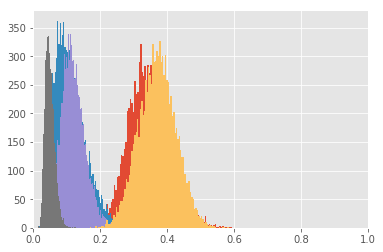

In [105]:
# Dany 
plt.hist(fitvar[0]['pi[20,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[20,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[20,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[20,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[20,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.xlim(0,1)
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.savefig("Dany")
plt.show()

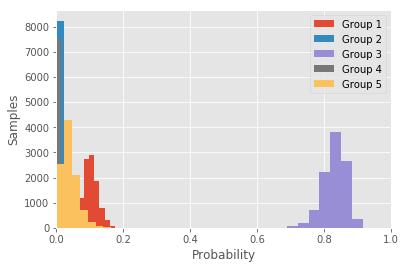

In [106]:
# Jorah
plt.hist(fitvar[0]['pi[49,1]'], label = 'Group 1')
plt.hist(fitvar[0]['pi[49,2]'], label = 'Group 2')
plt.hist(fitvar[0]['pi[49,3]'], label = 'Group 3')
plt.hist(fitvar[0]['pi[49,4]'], label = 'Group 4')
plt.hist(fitvar[0]['pi[49,5]'], label = 'Group 5')
plt.legend(loc='upper right')
plt.xlim(0,1)
plt.ylabel("Samples")
plt.xlabel("Probability")
plt.savefig("Jorah")
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 1)

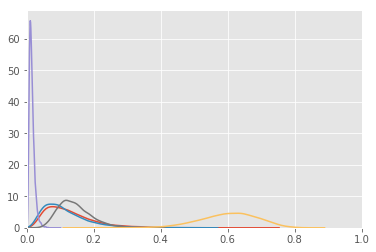

In [43]:
import seaborn as sns
sns.distplot(fitvar[0]['pi[18,1]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,2]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,3]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,4]'], kde=True, hist=False)
sns.distplot(fitvar[0]['pi[18,5]'], kde=True, hist=False)
plt.xlim(0, 1)

In [21]:
for key in fitvar[0]:
    if "pi" in key:
        temp.append(fitvar[0][key])
        

NameError: name 'temp' is not defined

In [ ]:
test = temp[0]

In [ ]:
test.reshape(10000)

In [ ]:
lol =(np.array(temp))

In [ ]:
temp[0][0]

In [ ]:
temp[0]

In [ ]:
final = np.reshape(lol, (iterations, n, 6))

In [ ]:
fix = np.zeros([iterations,n,6])

In [ ]:

for i in range(0, iterations):
    for j in range(0,n):
        for z in range(0,6):
            fix[i,j,z] = temp[]

In [ ]:
k = 6

In [ ]:
extract = pystan_utils.vb_extract(fit)
pitest = np.zeros((k,n,iterations))
for ki in range(1,k+1):
    for ni in range(n):
        for it in range(1001):
            pitest[ki-1,ni,it] = extract[0][extract[2][(ki-1)*n + ni]][it]

In [ ]:
np.shape(pitest)

In [ ]:
pi = fit.extract()["pi"]

In [ ]:
groups = np.argmax(pi,axis = 1)

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

In [ ]:
groups = fit.extract()["pi"]

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

In [ ]:
scores = []
for i in range(1, iterations//2):
    cluster1 = np.argmax(groups[i-4], axis = 1)
    cluster2 = np.argmax(groups[i-3], axis = 1)
    scores.append(adjusted_mutual_info_score(cluster1, cluster2))

In [ ]:
plt.plot(scores)

In [ ]:
groups = np.argmax(pi_hat,axis = 0)

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

# Prediction code


We note that
$$p(x_{ij} | X) = \sum_{\boldsymbol{\pi},\lambda} p(x_{i,j}|\boldsymbol{\pi},\lambda)p(\boldsymbol{\pi},\lambda|X)$$
where $\boldsymbol{\pi}$ is the collection of all group membership vectors, and $X$ is the network with all missing links excluded. This can be approximated by
$$p(x_{ij} | X) \approx \frac{1}{M} \sum_{m=1}^M p(x_{i,j} | \boldsymbol{\pi}^{(m)},\lambda^{(m)}, X) = \frac{1}{M} \sum_{m=1}^M \text{Poisson}({\boldsymbol{\pi}_i^{(m)}}^T \lambda^{(m)}\boldsymbol{\pi}_j^{(m)})$$
where $\boldsymbol{\pi}^{(m)}$ is the $m$'th posterior sample of $\boldsymbol{\pi}$ and similarly for $\lambda$.

In [16]:
model_code_pred= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;                           // priors on lambda
        real c;
        real d;
        
        int N_missing;                    // how many data points are missing
        int include[N,N];                 // mask to hide data from likelihood
        
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            for(j in 1:K)
                if(j==k){
                    lambda[k,j] ~ gamma(c,d);
                }else{
                    lambda[k,j] ~ gamma(a,b);
                }
        }
        
        for(i in 1:(N-1)){
            for(j in (i+1):N){     // assuming that X is symmetric
                if (include[i,j] == 1) { // check if observed
                    X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
                }
            }
        }
 
} generated quantities {
        int count = 1;
        int preds[N_missing];
        
        real scores[N_missing];
        
        // compute scores (ie how likely is the current weight) and make an actual prediction using the samples and then average over samples.
        for (i in 1:(N-1)) {
            for (j in (i+1):N) {
                    if (include[i,j] == 0) {
                        preds[count] = poisson_rng(pi[i]'*lambda*pi[j]);
                        scores[count] = poisson_lpmf(X[i,j] | pi[i]'*lambda*pi[j]);
                        count += 1;
                    }
                }
            }
}
"""

In [17]:
sm_pred = pystan.StanModel(model_code=model_code_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3e79ea646abc945acc0afb6e7ba263e NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpf3f_mhqa/stanfit4anon_model_b3e79ea646abc945acc0afb6e7ba263e_3831703588737850851.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
def generate_mask(X, N_missing):
    # Takes the matrix X, and the number of edges to remove (from lower triangular). 
    # Returns a mask of the same size as X.
    # if mask[i,j] == 1 then the edge i,j is to be included in the likelihood. if mask[i,j] == 0, then it is to be excluded
    N = X.shape[0]
    mask = np.ones(X.shape, dtype=int)
    all_data = list(itertools.product(range(N), range(N)))
    #N_missing = int(len(all_data)*frac)
    # remove diagonal elements 
    for edge in all_data:
        if edge[0] == edge[1]:
            all_data.remove(edge)
    
    # find missing indeces
    missing_idx = np.random.choice(len(all_data), N_missing, replace=True)
    missing_edges = set([all_data[i] for i in missing_idx])
    # add reverse edge to set of missing
    reverse = set([(j,i) for (i,j) in missing_edges if (j,i) not in missing_edges])
    missing_edges.update(reverse)
    
    missing_edges = list(missing_edges)
    
    # update mask
    for i,j in missing_edges:
        mask[i,j] = 0
    return mask, missing_edges

In [18]:
n = graph.shape[0]

k = 5
alpha = np.ones(k)

mask, missing_edges = generate_mask(graph, int(0.07*n*n))
N_missing = len(missing_edges)

iterations = 10000
data_pred = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : alpha, 
        'a' : 0.1, 'b' :  0.1, 'c': 0.5,'d': 0.5, 'include' : mask, 'N_missing' : N_missing}

In [19]:
# This is not very stable. Be aware that sometimes the VB algorithm fails, and the error we get is useless according to the STAN forums. The algorithm is, after all, experimental
fit_pred = sm_pred.vb(data=data_pred,iter=iterations, output_samples = iterations)

(array([130.,  30.,  20.,  22.,  30.,  25.,  42.,  80., 122., 533.]),
 array([2.79387399e-93, 9.89091497e-02, 1.97818299e-01, 2.96727449e-01,
        3.95636599e-01, 4.94545748e-01, 5.93454898e-01, 6.92364048e-01,
        7.91273197e-01, 8.90182347e-01, 9.89091497e-01]),
 <a list of 10 Patch objects>)

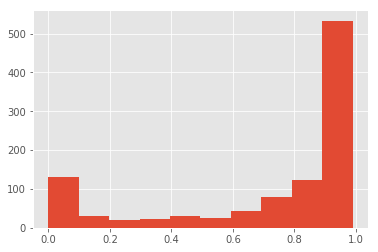

In [22]:
plt.hist(np.exp(pystan_utils.vb_extract_variable(fit_pred, 'scores', 'vector', [N_missing]))) # something is not quite right.